In [1]:
from qiskit.pulse import ScheduleBlock, Schedule
from qiskit.pulse.instructions import Play, Delay, SetFrequency, SetPhase, ShiftFrequency, ShiftPhase, Acquire
from qiskit.pulse.library import Gaussian, Constant, cos
from qiskit.pulse.transforms.alignments import AlignRight, AlignLeft, AlignEquispaced
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
from qiskit.circuit import Parameter
from qiskit.pulse.channels import MemorySlot, AcquireChannel, MeasureChannel, DriveChannel

import numpy as np
import qiskit.compiler as compiler

In [2]:
µs  = 1e-6
ns  = 1e-9
MHz = 1e6
GHz = 1e9
mV = 1e-3

# TODO: this can be stored in backend
parametric_pulses = [
    "constant",
    "zero",
    "square",
    "sawtooth",
    "triangle",
    "cos",
    "sin",
    "gaussian",
    "gaussian_deriv",
    "sech",
    "sech_deriv",
    "gaussian_square",
    "drag"
]

In [3]:
freq_qubit = Parameter("freq")
qubit = 0

spec_pulse_width = 3.5*µs
spec_pulse_amp = 14*mV

In [4]:
center = 6.21445*GHz
span   = 35 * MHz
step   = .5 * MHz
start  = center - span/2
end    = center + span/2
frequencies = np.arange(start, end, step)

print(f"Sweeping from {start/GHz} GHz to {end/GHz} GHz around {center/GHz} GHz with stepsize {step/MHz} MHz.")
#----------------------------------------------

sched = ScheduleBlock(f"resonator spectroscopy - stepsize {step/MHz} MHz")
sched += SetFrequency(freq_qubit, MeasureChannel(qubit))
sched += Play(Constant(int(spec_pulse_width/ns), amp = spec_pulse_amp), MeasureChannel(qubit))
sched += Delay(300, AcquireChannel(qubit), "Time of flight")
sched += Acquire(int(3*µs/ns), AcquireChannel(qubit), MemorySlot(qubit))

#----------------------------------------------
sweep = [ sched.assign_parameters({
    freq_qubit : f
}, inplace = False) for f in frequencies ]
print(f"Thats {len(sweep)} schedules")

Sweeping from 6.19695 GHz to 6.23195 GHz around 6.21445 GHz with stepsize 0.5 MHz.
Thats 70 schedules


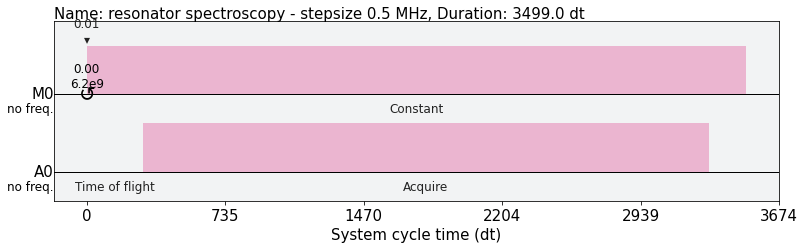

In [5]:
sweep[0].draw(style = IQXDebugging())

# Loading Tergite and the backend

In [6]:
from qiskit.providers.tergite import Tergite

chalmers = Tergite.get_provider()
backend = chalmers.get_backend("Pingu")
backend.set_options(shots = 1024)
backend.options.shots

1024

In [7]:
import tempfile
from pathlib import Path
Path(tempfile.gettempdir())

WindowsPath('C:/Users/axean/AppData/Local/Temp')

In [8]:
backend.run(
    sweep, 
    meas_level=1, 
    meas_return='avg',
    qobj_header={
        "frequencies" : frequencies,
        #"amplitudes"  : amplitudes
    }
)

Tergite: Job has been successfully submitted
